<a href="https://colab.research.google.com/github/JAntonioRosales/CE888-Data-Science/blob/main/labs/lab_6/Lab6_my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading and cleaning

In [102]:
# Loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.00,99.00,99.00,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.00,99.00,99.00,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.00,99.00,99.00,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,100,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,-0.53,5.63,-7.14,-4.08,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46,5.63,-0.92,-2.91,-4.17,2.82,3.40,8.64,6.84,6.80,-0.87,7.38,-3.50,8.88,7.43,5.39,2.23,-0.68,3.40,-0.58,...,8.59,3.45,0.87,9.27,-4.66,5.73,-0.49,8.35,1.94,5.00,-9.66,8.98,8.98,-9.81,9.13,9.08,9.08,3.98,0.73,9.03,8.98,9.22,8.93,9.13,9.27,-1.99,-9.95,-9.90,9.13,8.83,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,91,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,8.88,-8.69,-7.48,-8.83,-1.75,6.60,3.54,1.50,7.67,-0.44,9.22,8.74,9.03,9.08,8.93,3.74,3.20,-9.17,-8.98,8.79,-7.67,-3.06,9.13,8.40,-0.63,-7.18,0.58,8.88,9.27,...,2.77,8.11,-7.96,8.93,-0.87,-5.87,8.88,-1.12,-8.74,8.74,99.00,99.00,99.00,99.00,99.00,4.90,99.00,99.00,99.00,99.00,-0.29,0.92,-0.78,0.15,-0.10,0.00,-0.19,-0.87,-1.36,-0.58,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,39,99.00,99.00,99.00,99.00,-7.77,99.00,6.70,-6.75,99.00,99.00,99.00,99.00,-6.46,-1.65,-6.80,-6.41,-6.99,7.23,6.75,-6.99,6.55,99.00,99.00,99.00,99.00,0.49,-0.53,-6.94,-0.49,99.00,6.46,-0.53,99.00,99.00,-7.86,-0.34,99.00,-6.94,99.00,...,0.49,-0.24,99.00,99.00,-3.11,-6.65,99.00,-0.58,6.31,99.00,99.00,-7.86,99.00,99.00,

Sanity check to see if our features are read as numbers or strings.

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24983 entries, 0 to 24982
Columns: 101 entries, 0 to 100
dtypes: float64(100), int64(1)
memory usage: 19.3 MB


They are all numbers.

In [104]:
# Replacing the '99' values with NaNs (to create a test set)
df = df.replace(99, np.nan)

# Dropping the first column (number of jokes rated by that user)
df = df.drop(columns=[0])

df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,-0.53,5.63,-7.14,-4.08,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46,5.63,-0.92,-2.91,-4.17,2.82,3.40,8.64,6.84,6.80,-0.87,7.38,-3.50,8.88,7.43,5.39,2.23,-0.68,3.40,-0.58,4.42,...,8.59,3.45,0.87,9.27,-4.66,5.73,-0.49,8.35,1.94,5.00,-9.66,8.98,8.98,-9.81,9.13,9.08,9.08,3.98,0.73,9.03,8.98,9.22,8.93,9.13,9.27,-1.99,-9.95,-9.90,9.13,8.83,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,8.88,-8.69,-7.48,-8.83,-1.75,6.60,3.54,1.50,7.67,-0.44,9.22,8.74,9.03,9.08,8.93,3.74,3.20,-9.17,-8.98,8.79,-7.67,-3.06,9.13,8.40,-0.63,-7.18,0.58,8.88,9.27,8.50,...,2.77,8.11,-7.96,8.93,-0.87,-5.87,8.88,-1.12,-8.74,8.74,NaN,NaN,NaN,NaN,NaN,4.90,NaN,NaN,NaN,NaN,-0.29,0.92,-0.78,0.15,-0.10,0.00,-0.19,-0.87,-1.36,-0.58,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,NaN,NaN,-6.46,-1.65,-6.80,-6.41,-6.99,7.23,6.75,-6.99,6.55,NaN,NaN,NaN,NaN,0.49,-0.53,-6.94,-0.49,NaN,6.46,-0.53,NaN,NaN,-7.86,-0.34,NaN,-6.94,NaN,NaN,...,0.49,-0.24,NaN,NaN,-3.11,-6.65,NaN,-0.58,6.31,NaN,NaN,-7.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,NaN,NaN,NaN,-9.47,NaN,3.45,-0.92,-4.51,-4.13,-5.73,-9.51,2.82,NaN,NaN,NaN,NaN,-0.49,2.91,2.62,8.30,NaN,3.06,5.44,NaN,NaN,-0.68,2.04,NaN,NaN,1.

In [105]:
# Q6
df.iloc[12365, 47]

1.46

In [106]:
# Calculating jokes mean rating
joke_means = pd.DataFrame(data=np.nanmean(df.values, axis=0).reshape(1,-1), index=['mean'], columns=np.arange(1, df.shape[1]+1))
joke_means

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mean,0.904573,0.20846,0.316574,-1.449114,0.403556,1.594447,-0.429662,-0.624085,-0.557031,1.301231,1.805797,1.44929,-1.762882,1.396334,-1.706201,-3.104818,-1.115141,-0.635103,0.154227,-0.933997,2.095626,0.868662,0.109192,-1.68742,0.382373,1.286232,3.189821,1.51883,2.972455,-0.436493,2.198943,3.155988,-1.368648,0.859494,3.006351,3.3125,-1.363987,1.300479,1.067337,0.998635,...,2.45918,2.976021,0.246998,-0.667938,2.27382,2.541538,-0.863868,2.639132,2.559463,0.418405,-0.687494,2.757389,1.082492,-1.553548,-0.270715,2.520047,0.715392,1.751897,0.091667,1.122074,1.836562,0.902718,2.0284,0.694418,0.918927,0.344681,1.900667,2.10994,3.57472,0.612016,2.038527,1.179744,2.504041,1.173482,1.03913,1.528003,1.67375,0.767692,-0.031244,1.354711


In [107]:
# Best and worst jokes
b_score = joke_means.max(axis=1)[0]
b_joke = joke_means.T.index[joke_means.T['mean'] == b_score][0]
w_score = joke_means.min(axis=1)[0]
w_joke = joke_means.T.index[joke_means.T['mean'] == w_score][0]
print('Best joke:', b_joke, '. With mean score:', b_score)
print('Worst joke:', w_joke, '. With mean score:', w_score)

Best joke: 50 . With mean score: 3.6650848950824924
Worst joke: 58 . With mean score: -3.8338796373689963


### Validation Set

In [108]:
# Function to replace random ratings
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(orig != np.nan) # returns a tuple of coordinate pairs for each rating that is not NaN [DOESN'T WORK AS INTENDED]
  n_rated = len(rated[0])
  rand_ids = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][rand_ids], rated[1][rand_ids]] = 99
  return new_data, (rated[0][rand_ids], rated[1][rand_ids])

In [109]:
# Randomly replacing 10% of the ratings
df99s, validation_locs = replace(df.values, 0.1)
df99s = pd.DataFrame(data=df99s, columns=np.arange(1, df.shape[1]+1))
df99s

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,99.00,-9.37,1.50,99.00,-9.81,-8.50,99.00,7.82,2.86,9.13,-7.43,99.00,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,99.00,-6.84,-9.03,99.00,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,99.00,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,99.00,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,99.00,-0.92,7.14,9.03,-1.80,99.00,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,99.00,7.72,8.98,8.64,99.00,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,99.00,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,99.00,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,99.00,NaN,NaN,8.98,99.00,NaN,6.17,9.08,99.00,...,6.46,7.28,NaN,99.00,7.04,7.28,NaN,99.00,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,99.00,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,99.00,99.00,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,99.00,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,99.00,6.21,6.65,NaN,-8.30,99.00,2.82,...,99.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,99.00,NaN,NaN,99.00
4,8.50,99.00,-4.17,-5.39,1.36,1.60,99.00,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,99.00,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,99.00,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,99.00,3.01,3.83,99.00,NaN,NaN,NaN,99.00,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,99.00,-8.74,7.23,-0.53,5.63,-7.14,-4.08,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46,5.63,-0.92,-2.91,-4.17,2.82,3.40,8.64,6.84,6.80,-0.87,7.38,-3.50,8.88,99.00,5.39,2.23,-0.68,3.40,-0.58,4.42,...,8.59,3.45,0.87,9.27,99.00,5.73,-0.49,99.00,1.94,5.00,-9.66,8.98,8.98,-9.81,9.13,9.08,9.08,3.98,0.73,99.00,8.98,9.22,8.93,99.00,9.27,-1.99,-9.95,-9.90,9.13,8.83,99.00,-1.21,9.22,-6.70,8.45,9.03,99.00,99.00,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,99.00,-8.11,4.90,8.88,-8.69,-7.48,-8.83,-1.75,6.60,3.54,1.50,7.67,-0.44,9.22,8.74,9.03,9.08,99.00,3.74,3.20,-9.17,99.00,8.79,-7.67,-3.06,9.13,8.40,-0.63,-7.18,0.58,8.88,9.27,8.50,...,2.77,99.00,-7.96,99.00,-0.87,-5.87,8.88,-1.12,-8.74,8.74,NaN,NaN,NaN,NaN,NaN,4.90,NaN,NaN,NaN,NaN,-0.29,0.92,-0.78,0.15,-0.10,0.00,-0.19,99.00,-1.36,-0.58,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,99.00,8.45
24980,NaN,NaN,NaN,NaN,-7.77,99.00,6.70,-6.75,NaN,NaN,NaN,99.00,-6.46,99.00,-6.80,-6.41,-6.99,7.23,6.75,-6.99,6.55,NaN,NaN,NaN,NaN,0.49,-0.53,-6.94,-0.49,NaN,6.46,-0.53,NaN,NaN,-7.86,-0.34,NaN,-6.94,NaN,NaN,...,0.49,-0.24,NaN,NaN,-3.11,-6.65,NaN,-0.58,6.31,NaN,NaN,-7.86,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.00,NaN,99.00,NaN,NaN
24981,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,NaN,99.00,NaN,-9.47,NaN,3.45,-0.92,-4.51,-4.13,-5.73,-9.51,2.82,NaN,NaN,NaN,NaN,

### Latent Factor Modeling

In [110]:
n_latent_factors = 2

# Ratings matrix
user_ratings = df.values

# User preferences and item factors (initialized as random values)
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [111]:
# Original user preferences (random)
latent_user_preferences

array([[0.29303626, 0.61068486],
       [0.94327479, 0.41516375],
       [0.61653587, 0.57981469],
       ...,
       [0.66173735, 0.28715906],
       [0.07739178, 0.88965987],
       [0.05763428, 0.69855208]])

In [112]:
# Original items factors (random)
latent_item_features

array([[0.99454521, 0.89344912],
       [0.02879338, 0.26486898],
       [0.16560228, 0.61072189],
       [0.10972147, 0.15125268],
       [0.67500723, 0.51716508],
       [0.73193596, 0.18587309],
       [0.60651655, 0.81193928],
       [0.67446973, 0.25255851],
       [0.95514569, 0.77176596],
       [0.4217734 , 0.00243911],
       [0.96162597, 0.95657713],
       [0.03281126, 0.18884986],
       [0.2255745 , 0.48464347],
       [0.28269339, 0.80885008],
       [0.28527435, 0.35959059],
       [0.55316262, 0.09414902],
       [0.33062601, 0.72536772],
       [0.35532151, 0.01835434],
       [0.46821316, 0.47668932],
       [0.50002033, 0.99749855],
       [0.44513827, 0.96999367],
       [0.32613635, 0.80151961],
       [0.85421878, 0.93420446],
       [0.99687933, 0.07880746],
       [0.84603903, 0.06439911],
       [0.86338015, 0.10102728],
       [0.65399882, 0.51216197],
       [0.04131477, 0.58882792],
       [0.39505661, 0.12350286],
       [0.03720496, 0.31372171],
       [0.

In [113]:
# Function to predict a rating
def predict_rating(user_id, item_id):
  """ Predict a rating given a user_id and an item_id.
  """
  # Finding the row for the user
  user_preference = latent_user_preferences[user_id]

  #Finding the item to predict
  item_preference = latent_item_features[item_id]

  # Dot product of these vectors
  return user_preference.dot(item_preference)



# Function to adjust the users' preferences and items' factors
def train(user_id, item_id, rating, alpha=0.0001):

  # Predict the rating (using the function above) and calculate its error with the real rate
  predicted_rating = predict_rating(user_id, item_id)
  err =  predicted_rating - rating

  # Storing the previous user preferences
  user_pref_values = latent_user_preferences[user_id]

  # Updating the users' preferences based on the item features and vice versa
  latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
  latent_item_features[item_id] -= alpha * err * user_pref_values # Note that this uses the users' preferences before updating
  return err



# Stochastic Gradient Descent
def sgd(iterations):
  """ Iterate over all users and all items and train for 
      a certain number of iterations
  """
  mse_history = []
  for iteration in range(iterations):
    error = []
    # For each user and each item
    for user_id in range(latent_user_preferences.shape[0]):
      for item_id in range(latent_item_features.shape[0]):
        # Get the ground truth rating
        rating = user_ratings[user_id, item_id]
        # If it's not a NaN (testing) or 99 (validation)
        if not np.isnan(rating) and rating != 99.0:
          # Calculate and store the error, update the user preferences and item factors
          err = train(user_id, item_id, rating)
          error.append(err)
    # Calculate the MSE for all the predictions in an iteration
    mse = (np.array(error) ** 2).mean()   
    # If it's a multiple of X, print and store the MSE
    if (iteration % 1) == 0:
      print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
      mse_history.append(mse)
  return mse_history

Iteration 0/10:	MSE=26.138458
Iteration 1/10:	MSE=25.218296
Iteration 2/10:	MSE=24.931485
Iteration 3/10:	MSE=24.696907
Iteration 4/10:	MSE=24.464717
Iteration 5/10:	MSE=24.229583
Iteration 6/10:	MSE=23.991844
Iteration 7/10:	MSE=23.752970
Iteration 8/10:	MSE=23.514709
Iteration 9/10:	MSE=23.278810


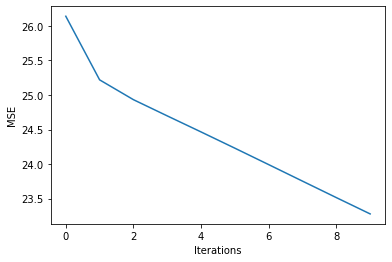

In [114]:
num_iter = 10
hist = sgd(num_iter) # Note how the MSE decreases with the number of iterations
plt.figure()
plt.plot(np.arange(0, num_iter, 1), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

### Predicting on the validation set

In [119]:
val_error = []
for pred in range(len(validation_locs[0])):
  # Get the user and item ID for the hidden ratings (99s)
  user = validation_locs[0][pred]
  item = validation_locs[1][pred]
  # Predict rating and save its error with the true rating
  pred_rating = predict_rating(user, item)
  err = pred_rating - user_ratings[user, item]
  val_error.append(err)
# Calculate the MSE for the validation set
val_mse = np.nanmean(np.array(val_error) ** 2) # (np.array(val_error) ** 2).mean() doesn't work because some 99s replaced NaNs (they shouldn't have...)
print("Validation set MSE:", val_mse)

Validation set MSE: 23.053993792375135


### Predicting on the testing set

In [124]:
np.where(df == np.nan) # Wanted to get the coordinates (user, item) with NaNs to then predict on them, BUT IT DOESN'T WORK AS INTENDED

(array([], dtype=int64), array([], dtype=int64))

In [125]:
# Q6 - In the jokes dataset, what's the rating that user 13219 has given to joke 27?
# Give your answer with two decimal values (e.g., 0.13).
df.iloc[13219, 27]

0.68

## Movies Dataset

In [128]:
#Importing Items sheet
mov_items = pd.read_excel('/content/drive/My Drive/UNIVERSITY OF ESSEX/CE888 - Data Science/Labs/movies_latent_factors.xlsx', sheet_name='Items')
mov_items

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9806,The Incredibles (2004),0.159967,-0.051123,0.311183,1.841867,-1.952736,-0.836041,0.639252,-0.413082,-0.310868,0.448225,-0.846044,-0.158192,-0.649164,0.045580,1.017861
96,10020,Beauty and the Beast (1991),1.286288,0.004957,-0.157640,2.579640,-0.042687,-0.256582,-0.007971,0.458163,0.091394,0.323339,-0.862833,-0.508185,0.994535,0.868700,-0.487076
97,36657,X-Men (2000),0.811901,-0.893280,0.668953,-0.885074,-1.070468,-0.973154,-0.037449,-0.925609,-0.122112,-0.328822,-0.163103,-0.307299,0.642105,-1.355542,0.067790
98,36658,X2: X-Men United (2003),1.161006,-0.715613,0.712633,-0.688808,-0.717785,-1.007047,-0.267268,-0.802322,-0.249239,-0.540419,-0.291422,-0.240216,0.290714,-1.217250,-0.288130


In [129]:
#Importing Users sheet
mov_users = pd.read_excel('/content/drive/My Drive/UNIVERSITY OF ESSEX/CE888 - Data Science/Labs/movies_latent_factors.xlsx', sheet_name='Users')
mov_users

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
1,156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
2,5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
3,174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4,4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669
5,783,-0.020301,-0.031919,-0.036955,0.033690,0.000174,-0.003178,0.054474,0.045424,-0.053308,0.003437,-0.041750,0.059725,-0.021647,0.039873,-0.061857
6,3878,-0.091462,0.215879,-0.180453,0.085408,-0.321094,0.227947,0.053767,0.038017,0.097141,-0.139872,0.029253,0.214467,0.189250,0.065990,0.102776
7,768,0.000819,-0.009229,-0.019228,0.002703,0.012869,0.006655,0.007687,0.018747,0.014705,-0.009256,-0.010116,-0.010051,-0.002108,0.043223,-0.006670
8,4469,-0.030528,-0.011537,-0.042822,-0.014378,0.031338,0.012297,-0.000038,-0.010264,-0.006781,-0.019950,-0.014435,0.010926,0.024400,0.005318,-0.007983
9,1882,-0.083093,-0.029160,0.013748,0.022716,-0.062732,-0.080670,-0.019723,0.013253,-0.091305,-0.090687,0.030638,-0.113364,-0.021325,0.181508,0.022357


In [137]:
# Q7 - In the movies dataset, what's the loading (i.e., value) of Factor3 for the movie with ID=1637?
# Give your answer with three decimal values (e.g., 0.123).
ind = mov_items.index[mov_items['Movie ID'] == 1637][0]
mov_items.loc[ind, 'Factor3']

-0.8404059833993195

In [143]:
# Q8 - In the movies dataset, which of the following IDs corresponds to the movie with the lowest loading of factor 12?
lowest = mov_items['Factor12'].min()
ind = mov_items.index[mov_items['Factor12'] == lowest][0]
mov_items.loc[ind, 'Movie ID']

597

In [156]:
# Q9 - In the movies dataset, predict the rating that the user with ID 174 will give to the movie with ID 9741. Give your answer with two decimal values (e.g., 0.12).
user = mov_users.index[mov_users['User'] == 174][0]
item = mov_items.index[mov_items['Movie ID'] == 9741][0]
mov_users_arr = mov_users.drop(columns='User').values
mov_items_arr = mov_items.drop(columns=['Movie ID', 'Title']).values

In [157]:
# Function to predict a rating in the movies dataset
def predict_rating_movies(user_id, item_id):
  """ Predict a rating given a user_id and an item_id.
  """
  # Finding the row for the user
  user_preference = mov_users_arr[user_id]

  #Finding the item to predict
  item_preference = mov_items_arr[item_id]

  # Dot product of these vectors
  return user_preference.dot(item_preference)

In [158]:
predict_rating_movies(user, item)

0.050461621236451974

In [159]:
# Q10 - In the movies dataset, predict the rating that the user with ID 3878 will give to the movie with ID 105. Give your answer with two decimal values (e.g., 0.12).
user = mov_users.index[mov_users['User'] == 3878][0]
item = mov_items.index[mov_items['Movie ID'] == 105][0]
predict_rating_movies(user, item)

0.9289827867793355

In [178]:
# Q11 - In the movies dataset, if you had to recommend 2 movies to the user with ID=3048, which ones would you choose?
user = mov_users.index[mov_users['User'] == 3048][0]
pred_scores = []
for mov in range(mov_items.shape[0]):
  pred_score = predict_rating_movies(user, mov)
  pred_scores.append(pred_score)
og_pred_scores = pd.DataFrame(data=pred_scores)
og_pred_scores

,0
0,-0.183987
1,-0.146073
2,1.057426
3,0.216711
4,-0.501765
...,...
95,-0.193045
96,-1.062856
97,0.084414
98,-0.091907


In [180]:
pred_scores.sort()
sorted_pred_scores = pd.DataFrame(data=pred_scores)
sorted_pred_scores

,0
0,-1.346810
1,-1.336999
2,-1.330207
3,-1.062856
4,-1.051343
...,...
95,1.057426
96,1.115526
97,1.197216
98,1.216807


In [195]:
top2 = sorted_pred_scores.iloc[-2:].values
movie_idxs = []
for score in top2:
  movie_idx = og_pred_scores.index[og_pred_scores[0] == score[0]][0]
  movie_idxs.append(movie_idx)
movie_idxs

[50, 5]

In [196]:
for idx in movie_idxs:
  print('Movie ID:', mov_items.loc[idx, 'Movie ID'])

Movie ID: 603
Movie ID: 24


In [198]:
# Q12 - In the movies dataset, if you had to recommend 3 movies to the user with ID=2665, which ones would you choose?
user = mov_users.index[mov_users['User'] == 2665][0]
pred_scores = []
for mov in range(mov_items.shape[0]):
  pred_score = predict_rating_movies(user, mov)
  pred_scores.append(pred_score)
og_pred_scores = pd.DataFrame(data=pred_scores)

pred_scores.sort()
sorted_pred_scores = pd.DataFrame(data=pred_scores)

top3 = sorted_pred_scores.iloc[-3:].values
movie_idxs = []
for score in top3:
  movie_idx = og_pred_scores.index[og_pred_scores[0] == score[0]][0]
  movie_idxs.append(movie_idx)

for idx in movie_idxs:
  print('Movie ID:', mov_items.loc[idx, 'Movie ID'])

Movie ID: 2502
Movie ID: 2501
Movie ID: 604
